# Example 1: e-process for testing a scale-invariant Gaussian

E-process for testing whether the signal-to-noise ratio (mean over standard deviation) of a Gaussian is zero under a coarsening of the filtration.

This example comes from [Perez-Ortiz et al. (2022)](https://arxiv.org/abs/2208.07610).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ecombine as ec

In [2]:
sns.set_theme(
    style="whitegrid", 
    palette="colorblind", 
    font="Avenir", 
    font_scale=1.75,
)

rng = np.random.default_rng(20221026)

## Setup

Suppose that the data $X_1, \dotsc, X_n$ is sequentially samples from $\mathcal{N}(\mu, \sigma^2)$. 
Consider the hypothesis test
$$
\mathcal{H}_0 : \frac{\mu}{\sigma} = \delta_0 \quad \text{vs.}\quad \mathcal{H}_1 : \frac{\mu}{\sigma} = \delta_1,
$$
for some $\delta_0 \neq \delta_1$.
The parameter of interest $\delta := \mu/\sigma$ is scale-invariant, in the sense that it is invariant to the mapping $(\mu, \sigma) \mapsto (c\mu, c\sigma)$ for any $c \in \mathbb{R}^+$.

Following Perez-Ortiz et al.'s example, fix $\delta_0 = 0$ and consider the following GROW (growth-rate optimal in the worst case) e-statistic, with a mixture of $\mathcal{N}(0, \rho)$ taken over the potential alternatives in $\delta_1$:
$$
\tilde{T}_1 = 1 \quad \text{and} \quad \tilde{T}_2 = \frac{\sqrt{2\rho^2+1} \cdot (X_1^2+X_2^2)}{\rho^2(X_1 - X_2)^2 + (X_1^2 + X_2^2)},
$$
for the first two sample sizes ($n=1, 2$).

As shown in the paper, the GROW e-statistic is valid at any $\mathbb{G}$-stopping time (or "$\mathbb{G}$-anytime-valid"), where $\mathbb{G} = (\mathcal{G}_t)_{t\geq0}$ is a scale-invariant coarsening of the data filtration $\mathbb{F} = (\sigma(X_1, \dotsc, X_t))_{t\geq 0}$:
$$
\mathcal{G}_t = \sigma\left( \frac{X_1}{|X_1|}, \frac{X_2}{|X_1|}, \dotsc, \frac{X_t}{|X_1|} \right).
$$
Intuitively, $\mathbb{G}$ removes from $\mathbb{F}$ the scale information about the initial data point $X_1$ and retains only its sign.
    
Now consider the following stopping time: for some $0 < a < b$,
$$
\tau = \begin{cases}
    2 & \mbox{if } |X_1| \in [a, b]; \\
    1 & \mbox{otherwise}.
\end{cases}
$$
This is a $\mathbb{F}$-stopping time that is not a $\mathbb{G}$-stopping time.

In [3]:
def compute_e_grow(x1, x2, rho):
    """Compute the GROW e-statistic at T=1 and T=2 
    for the scale-invariant Gaussian hypotheses.
    
    N(0, rho) mixture is taken over the alternative.
    """
    t1 = 1
    t2 = (
        np.sqrt(2 * rho ** 2 + 1) * (x1 ** 2 + x2 ** 2)
    ) / (
        rho ** 2 * (x1 - x2) ** 2 + (x1 ** 2 + x2 ** 2)
    )
    return t1, t2


def compute_stopped_e(x1, x2, rho, a, b):
    """Return the statistic at a stopping time tau = 1 + I(a <= |x1| <= b)."""
    t1, t2 = compute_e_grow(x1, x2, rho)
    return np.where(
        np.logical_and(a <= np.abs(x1), np.abs(x1) <= b),
        t2,
        t1,
    )

In [4]:
compute_stopped_e(1.0, -0.5, 100, 0.44, 1.70)

array(0.0078565)

## Reproducing Perez-Ortiz et al.'s Result

At the $\mathbb{F}$-stopping time $\tau$, we expect to see that $\mathbb{E}_{N(0,I_2)}[\tilde{T}_\tau] \approx 1.19$, despite the fact that the statistic is a valid e-statistic at any $\mathbb{G}$-stopping times.


expectation of the stopped statistic: 1.15936 +/- 0.03114


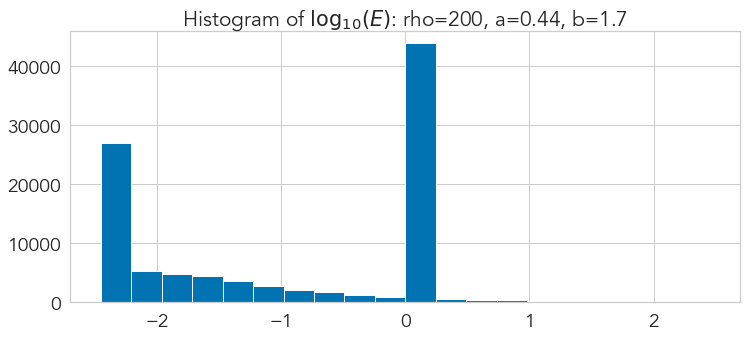

In [5]:
n = 100000
rho = 200
a, b = 0.44, 1.70
# rho = 200
# a, b = 0.44, 1.70

X = rng.normal(0, 1, size=(n, 2))
stopped_e = compute_stopped_e(X[:, 0], X[:, 1], rho, a, b)
print("expectation of the stopped statistic: {:.5f} +/- {:.5f}".format(
    stopped_e.mean(), 
    stopped_e.std() / np.sqrt(n),
))

# take log base 10
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(np.log10(stopped_e), bins=20)
ax.set(
    title=r"Histogram of $\log_{10}(E)$: " + f"rho={rho}, a={a}, b={b}",
)
None

The mode at $10^0=1$ corresponds to the ~43% mass in the case $\tau=1$. The rest, in the case $\tau=2$, most of the mass is in the area below 1.

In [6]:
# P(tau=2)
(stopped_e != 1).mean()

0.56858

In [7]:
# P(T2 > 1)
(stopped_e > 1).mean()

0.02985

## E-lifting

The e-lifting result of our work says that this issue can be fixed simply by applying an adjuster to the e-process and "lift" it into the larger filtration. We show this empirically:

expectation of the stopped statistic: 0.04486 +/- 0.00122


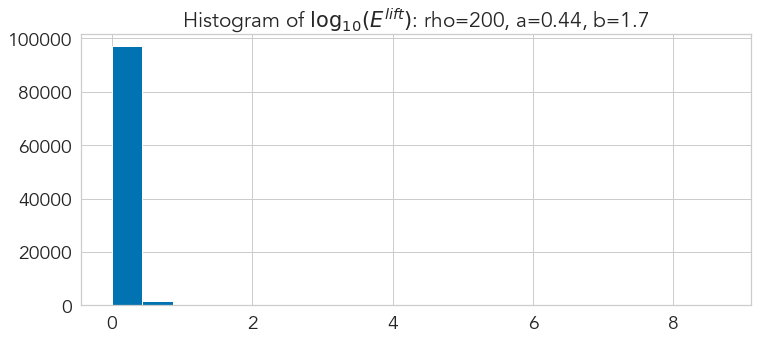

In [8]:
# taking the running maximum over t=1,2 in this case means taking max with T1=1
adjusted_e = ec.adjuster(stopped_e, use_maximum=False, kappa=None)
# adjusted_e = ec.p_to_e_calibrator(np.minimum(1, 1 / np.maximum(stopped_e, 1)))
print("expectation of the stopped statistic: {:.5f} +/- {:.5f}".format(
    adjusted_e.mean(), 
    adjusted_e.std() / np.sqrt(n),
))

# NO log base 10
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(adjusted_e, bins=20)
ax.set(
    title=r"Histogram of $\log_{10}(E^{lift})$: " + f"rho={rho}, a={a}, b={b}",
)
None


Since most (97%) of the values were already below 1, the adjuster achieves a very low e-statistic.

To see that this adjusted e-lifted statistic still has power, we can test it under an alternative distribution:

**[it is difficult to have any power with 2 data points... think of a setup with more data!]**

In [9]:
# alternative dist: X1 ~ N(1, 0.01^2) [almost always tau=2]; X2 ~ N(100, 1) [same delta1]
delta1 = 1
sig1 = 1
sig2 = 1
X1 = rng.normal(delta1 * sig1, sig1, size=n)
X2 = rng.normal(delta1 * sig2, sig2, size=n)

stopped_e = compute_stopped_e(X1, X2, rho, a, b)
print("expectation of the stopped statistic: {:.5f} +/- {:.5f}".format(
    stopped_e.mean(), 
    stopped_e.std() / np.sqrt(n),
))

expectation of the stopped statistic: 1.67150 +/- 0.04149


In [10]:
# P(tau=2)
(stopped_e == 1).mean()

0.45688

In [11]:
adjusted_e = ec.adjuster(stopped_e, use_maximum=False, kappa=None)
print("expectation of the stopped statistic: {:.5f} +/- {:.5f}".format(
    adjusted_e.mean(), 
    adjusted_e.std() / np.sqrt(n),
))

expectation of the stopped statistic: 0.07102 +/- 0.00158


## Testing Proposition 1 (Randomize-then-lift)

To disprove Ppn. 1, we can take $(T_t)_{t \geq 0}$, which is adapted to $\mathbb{G}$, and show that it is still not valid at a $\mathbb{F}$-stopping time (either in the e-/p-value sense) after randomized adjustment:
$$
\mathbb{E}_{(X_1, X_2) \sim N(0,I^2); U \sim Unif(0,1)}\left[f\left(\frac{U}{\tilde{T}_\tau} \wedge 1\right)\right] > 1.
$$
Here, $U$ is independent of $(X_1, X_2)$, and $f$ is any admissible p-to-e calibrator ([Vovk and Wang, 2021](https://doi.org/10.1214/20-AOS2020)), e.g., $f(p) = \kappa p^{\kappa-1}$ for any $\kappa \in (0,1)$.

In [12]:
X = rng.normal(0, 1, size=(n, 2))
u = rng.uniform(size=n)
rand_adjusted_e = ec.p_to_e_calibrator(np.minimum(u / stopped_e, 1), kappa=0.5)
print("expectation of the stopped statistic: {:.5f} +/- {:.5f}".format(
    rand_adjusted_e.mean(), 
    rand_adjusted_e.std() / np.sqrt(n),
))

expectation of the stopped statistic: 0.88363 +/- 0.00524


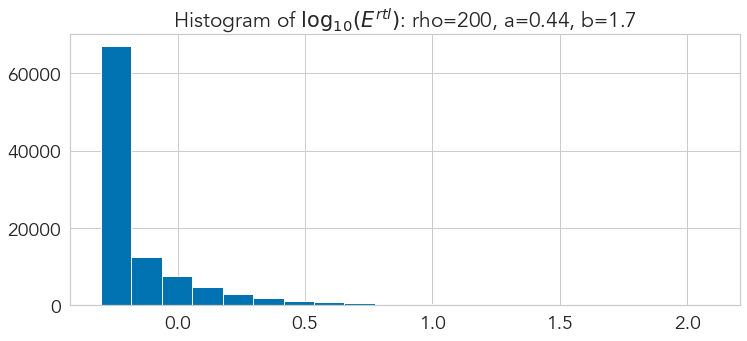

In [13]:
# take log first
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(np.log10(rand_adjusted_e), bins=20)
ax.set(
    title=r"Histogram of $\log_{10}(E^{rtl})$: " + f"rho={rho}, a={a}, b={b}",
)
None